In [79]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [80]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [98]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import text

In [82]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [83]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [84]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [85]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [86]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [87]:
# Find the most recent date in the data set.
engine.execute("SELECT Date FROM measurement ORDER BY DATE DESC LIMIT 1").fetchall()

[('2017-08-23',)]

In [88]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent = session.query(measurement.date).order_by(measurement.date.desc()).first()

In [89]:
# Calculate the date one year from the last date in data set.
last_year = dt.date(2017,8,23) - dt.timedelta(365)

# Perform a query to retrieve the data and precipitation scores
data = session.query(measurement.date, measurement.prcp).\
    filter(last_year < measurement.date).\
    order_by(measurement.date).all()
# Save the query results as a Pandas DataFrame and set the index to the date column
data = pd.DataFrame(data)
data.head()

,0,1
0,2016-08-24,0.08
1,2016-08-24,2.15
2,2016-08-24,2.28
3,2016-08-24,NaN
4,2016-08-24,1.22


In [90]:
data= data.rename(columns={0:"Date", 1:"Pcrp"})

In [91]:
# Sort the dataframe by date
data = data.sort_values(by=['Date'], ascending=False)

<AxesSubplot:title={'center':'Precipitation 1 Year-to-Date'}>

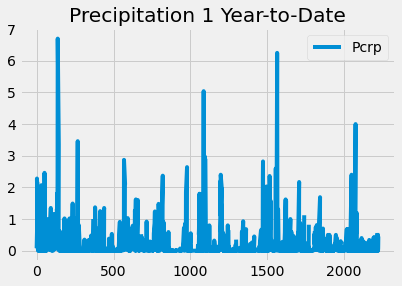

In [92]:
# Use Pandas Plotting with Matplotlib to plot the data
data.plot(title="Precipitation 1 Year-to-Date")

In [93]:
# Use Pandas to calcualte the summary statistics for the precipitation data
data["Pcrp"].describe()

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Pcrp, dtype: float64

# Exploratory Station Analysis

In [94]:
# Design a query to calculate the total number stations in the dataset
stations = session.query(measurement).group_by(measurement.station).count()
print(f'There are {stations} stations in the dataset.')

There are 9 stations in the dataset.


In [100]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
most_active = session.query(measurement.station, func.count(measurement.station).label('Counts')).\
    group_by(measurement.station).\
    order_by(text('Counts DESC')).all()

most_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [101]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_stationid = session.query(measurement.station, func.count(measurement.station).label('Counts')).\
    group_by(measurement.station).\
    order_by(text('Counts DESC')).limit(1)[0][0]


In [103]:
most_active_temperature = session.query(func.min(measurement.tobs),
                                       func.max(measurement.tobs),
                                       func.avg(measurement.tobs)).filter(measurement.station==most_active_stationid).all()
most_active_temperature

[(54.0, 85.0, 71.66378066378067)]

In [110]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_ytd_temperature = session.query(measurement.tobs).\
    filter(measurement.station==most_active_stationid).\
    filter(measurement.date>= last_year).all()

df_active_ytd_temperature = pd.DataFrame(active_ytd_temperature)
df_active_ytd_temperature = df_active_ytd_temperature.rename(columns={0:'tobs'})
df_active_ytd_temperature.head()

,tobs
0,77.0
1,77.0
2,80.0
3,80.0
4,75.0


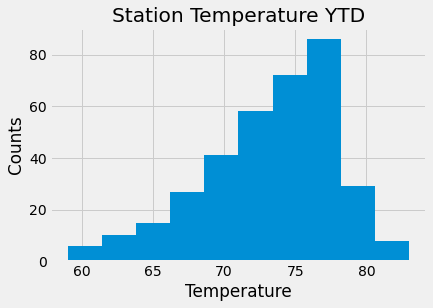

In [113]:
fig, ax = plt.subplots()
ax.hist(df_active_ytd_temperature);
ax.set(title="Station Temperature YTD",
      xlabel="Temperature",
      ylabel="Counts");

# Close session

In [114]:
# Close Session
session.close()